# Driver of Neural ODE

We use `odeint` from `torchdiffeq`, which is a general-purpose algorithm for solving initial value problems. More specifically, an initial value problem consists of an ODE 
$$
\frac{dy}{dt} = f(t, y)
$$
with an initial value,
$$
y(t_0) = y_0.
$$
See the github repo: https://github.com/rtqichen/torchdiffeq

## Import Modules

In [31]:
# import modules
import math
import numpy as np
import os

import matplotlib as mpl
mpl.rc('image', cmap='jet')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# %matplotlib inline

import torch
gpu = 0
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

from ode_mod import NeuralODE, OdeDataset, OdeModel, OdeTrainer

## Data

In [32]:
# # data
# # test of dataloader
# y = np.linspace(0,9,10).astype('float32')
# t = np.linspace(0,9,10).astype('float32')

if False:
    # red noise
    from ode_AM_index_config import get_red_noise as get_data
    gamma = [0.06]
    true_t, true_y = get_data(gamma=gamma, data_size=10000)
else:
    # annular mode
    from read_AM_index_mod import get_AM_index as get_data
    t, y, p = get_data()

t_T = torch.from_numpy(t)
if y.ndim == 1:
    y_T = torch.from_numpy(y)[:,None]
else:
    y_T = torch.from_numpy(y)

print(f't.shape = {t_T.shape}, y.shape = {y_T.shape}')
# plot(true_y)


Reading from saved data ......
Use pressure levels = [   1.    2.    3.    5.    7.   10.   20.   30.   50.   70.  100.  125.
  150.  175.  200.  225.  250.  300.  350.  400.  450.  500.  550.  600.
  650.  700.  750.  775.  800.  825.  850.  875.  900.  925.  950.  975.
 1000.]

t.shape = torch.Size([21535]), y.shape = torch.Size([21535, 37])


## Hyperparameters

In [33]:
# hyperparameters
hyp_param = dict(ode = dict(adjoint = False, # False
                            method = 'midpoint',
                            options = dict(step_size=0.2),    # step_size for fixed grid ODE solver in unit of t
                           ),
                                       
                 data = dict(batch_size = 40,    # 20, 200, # size of mini-batch
                             batch_time = 21,    # 10,    # the length in 't' integrated by odeint (cf. lag in LIM)
                             test_frac = 0.1,     # 0.1,    # fraction of 'dataset' used for test data
                             First_batch_only = False, #False,    # overfit the first batch only for the purpose of debugging
                            ),
                
                train = dict(epochs = 20,   # 40, 20  # number of epochs
                             output_freq = 500,    # output per the number of batches for each epoch
                             lr_scheduler = dict(method = 'StepLR',    # None, 'StepLR', ...
                                                 # if `method = StepLR`, 
                                                 # the learning rate decays by gamma every step_size epochs
                                                 StepLR = dict(step_size=5, gamma=0.5),
                                                ),
                             max_norm = None,    # maximum norm used to clip the norms of model parameters
                            ),     

                # L1 loss is more robust to outliers, but its derivatives are not continuous
                # L2 loss is sensitive to outliers, but gives a more stable and closed form solution
                loss_fn = dict(method = 'MSELoss', # 'MSELoss', 'L1Loss'
                              ),

                # https://ruder.io/optimizing-gradient-descent/
                # RMSprop is an adaptive learning rate algorithm
                # Adam adds bias-correction and momentum to RMSprop.
                optimizer = dict(method = 'RMSprop',     # 'RMSprop', 'Adam', 'SGD'
                                learning_rate = 1e-3,    # 1e-3,    # default LR
                                RMSprop = dict(),
                                Adam = dict(),
                                SGD = dict(momentum=0, weight_decay=0),
                                ),

                func = dict(method = 'Tanh',
                            size = [y_T.shape[1]]*3,
                           ),
                )
hyp_param['train']['First_batch_only'] = hyp_param['data']['First_batch_only']

print(f'hyperpamameters:\n{hyp_param}')

hyperpamameters:
{'ode': {'adjoint': False, 'method': 'midpoint', 'options': {'step_size': 0.2}}, 'data': {'batch_size': 40, 'batch_time': 21, 'test_frac': 0.1, 'First_batch_only': False}, 'train': {'epochs': 20, 'output_freq': 500, 'lr_scheduler': {'method': 'StepLR', 'StepLR': {'step_size': 5, 'gamma': 0.5}}, 'max_norm': None, 'First_batch_only': False}, 'loss_fn': {'method': 'MSELoss'}, 'optimizer': {'method': 'RMSprop', 'learning_rate': 0.001, 'RMSprop': {}, 'Adam': {}, 'SGD': {'momentum': 0, 'weight_decay': 0}}, 'func': {'method': 'Tanh', 'size': [37, 37, 37]}}


## Model

In [34]:
nn = NeuralODE(y_T, t_T, hyp_param, verbose=False)

Loading data ......

Initializing model ......

Training model ......
Epoch 1(LR=[0.001])
-------------------------------
loss: 15.921699  [    0/19364]
Test Error: 
 Avg loss: 0.707960 

Epoch 2(LR=[0.001])
-------------------------------
loss: 0.754901  [    0/19364]
Test Error: 
 Avg loss: 0.654955 

Epoch 3(LR=[0.001])
-------------------------------
loss: 0.472812  [    0/19364]
Test Error: 
 Avg loss: 0.686245 

Epoch 4(LR=[0.001])
-------------------------------
loss: 0.628131  [    0/19364]
Test Error: 
 Avg loss: 0.649060 

Epoch 5(LR=[0.001])
-------------------------------
loss: 0.638869  [    0/19364]
Test Error: 
 Avg loss: 0.659511 

Epoch 6(LR=[0.0005])
-------------------------------
loss: 0.585050  [    0/19364]
Test Error: 
 Avg loss: 0.641540 

Epoch 7(LR=[0.0005])
-------------------------------
loss: 0.522241  [    0/19364]
Test Error: 
 Avg loss: 0.641186 

Epoch 8(LR=[0.0005])
-------------------------------
loss: 0.799090  [    0/19364]
Test Error: 
 Avg loss: 0

## Analysis

In [35]:
## plot(t, true_y, lag_time=50, model=model)
# for name, param in nn.model.named_parameters():
#     print(f'params: {name}, {param}')

dict_keys(['train_loss', 'func.net.0.weight.pmean', 'func.net.0.weight.gmean', 'func.net.0.bias.pmean', 'func.net.0.bias.gmean', 'func.net.2.weight.pmean', 'func.net.2.weight.gmean', 'func.net.2.bias.pmean', 'func.net.2.bias.gmean', 'pmean', 'gmean', 'grad_norm', 'test_loss'])
9700


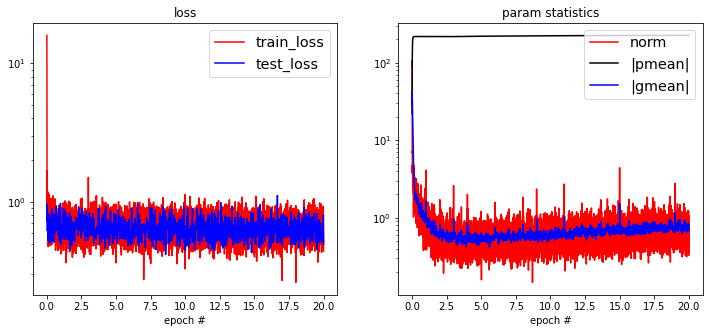

In [36]:
print(nn.trainer.save.keys())
print(len(nn.trainer.save["train_loss"]))
nn.trainer.plot_loss(log_scale=True)

In [37]:
lag_time = 90
with torch.no_grad():
    yf= np.squeeze(nn.model(y_T[:-lag_time], t_T[:lag_time+1]).detach().numpy())


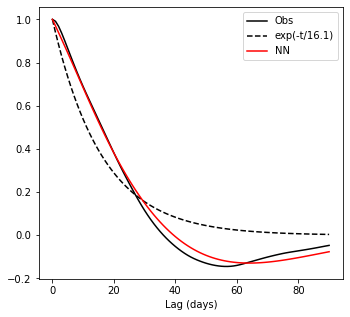

In [38]:
from AM_plot_mod import plot_cov

k = np.isin(p, 10).nonzero()[0][0]
plot_cov(y, yf=yf, k=k, lag_time=lag_time, model_name='NN')


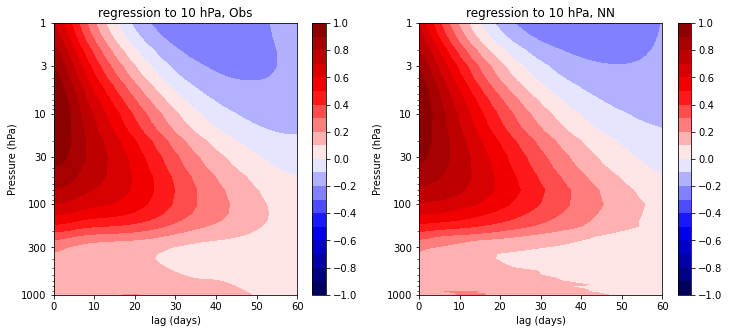

In [39]:
from AM_plot_mod import plot_lag_reg

plot_lag_reg(y, p, yf, model_name='NN')

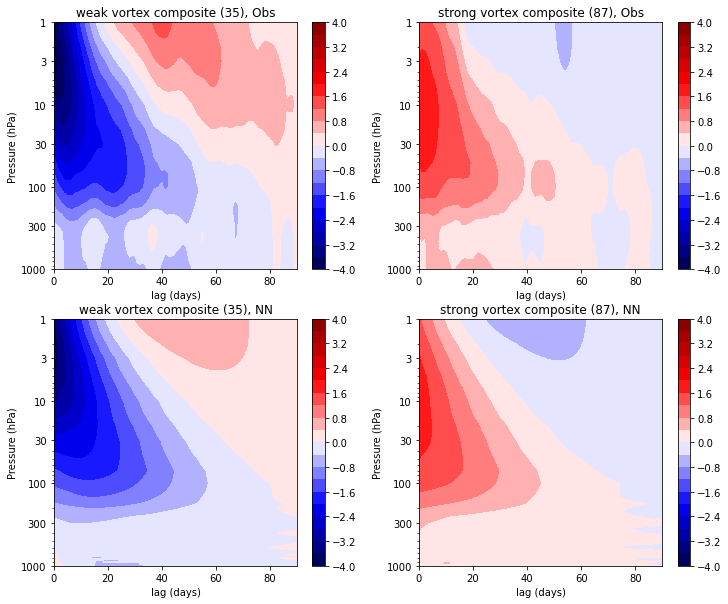

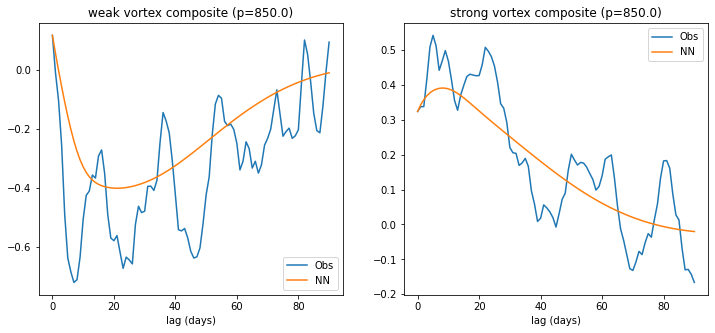

In [40]:
from AM_plot_mod import plot_event

plot_event(y, p, yf=yf, lag_time=lag_time, model_name='NN')
